In [1]:
import pandas as pd
import numpy as np
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [2]:
df= pd.read_csv("train.csv")
base_path = "./images/"

In [3]:
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [4]:
samples=20000
#df= df.loc[:samples, :]
df = df.loc[df["id"].str.startswith("00", na= False), :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [5]:
num_classes

5346

In [6]:
num_data

6120

In [7]:
data =  pd.DataFrame(df["landmark_id"].value_counts())

data.reset_index(inplace=True)
#data.columns = ['landmark_id', 'count']
data.head()

,landmark_id,count
0,138982,31
1,83144,14
2,126637,7
3,194914,7
4,109169,6


In [8]:
data.tail()

,landmark_id,count
5341,71434,1
5342,71336,1
5343,71228,1
5344,71145,1
5345,202981,1


In [9]:
data.columns = ['landmark_id', 'count']

In [10]:
data['count'].describe()

count    5346.000000
mean        1.144781
std         0.641260
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: count, dtype: float64

(array([5.344e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

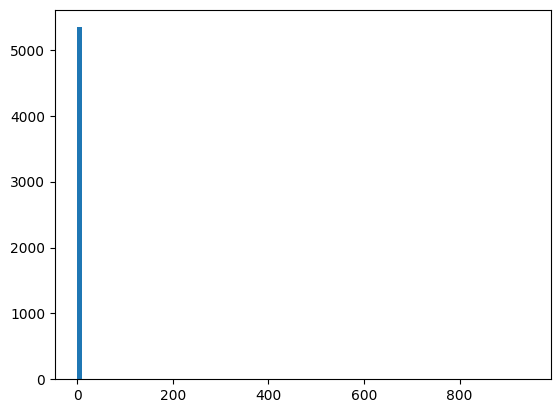

In [11]:
plt.hist(data['count'], 100, range = (0,944), label = 'test')

In [12]:
data['count'].between(0,5).sum()

5339

In [13]:
data['count'].between(5,10).sum()

14

(array([2., 1., 1., ..., 1., 1., 2.]),
 array([2.70000e+01, 6.00000e+01, 1.24000e+02, ..., 2.02950e+05,
        2.02972e+05, 2.02981e+05]),
 <BarContainer object of 5345 artists>)

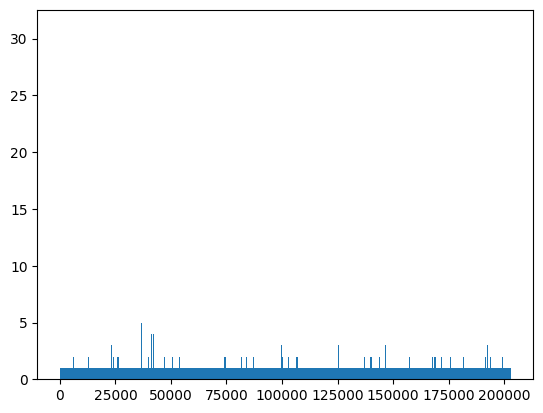

In [14]:
plt.hist(df['landmark_id'], bins = df['landmark_id'].unique())

In [15]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [16]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [17]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [18]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [19]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num, :]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    '''if im is None or im.size == 0:
        print("Error loading image")'''
    return im, label


4 sample images from random classes


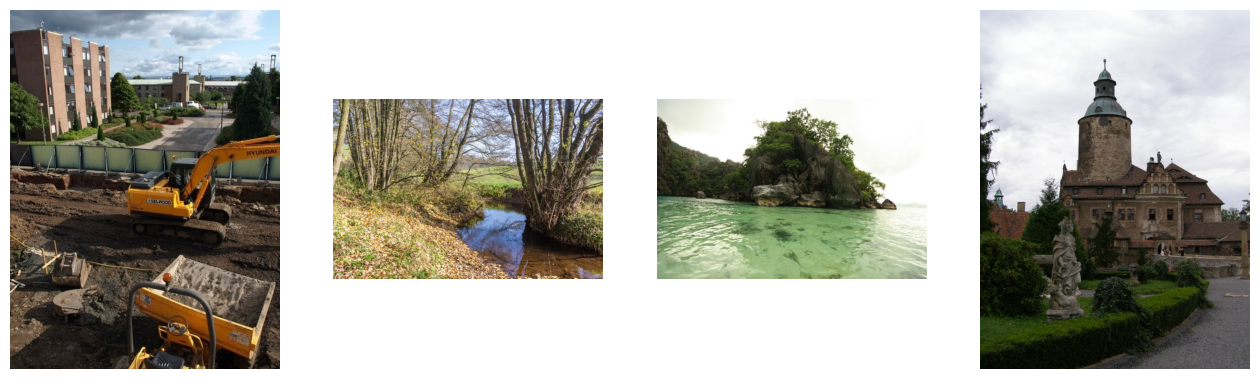

In [20]:
print("4 sample images from random classes")
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [30]:
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
#import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [31]:
learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5) 

In [32]:
model = Sequential()
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,8

 Total params: 161,472,814 (615.97 MB)

 Trainable params: 161,472,808 (615.97 MB)

 Non-trainable params: 6 (24.00 B)

In [36]:
from keras.optimizers import RMSprop

optim1= RMSprop(learning_rate= learning_rate)
#optim1 = keras.optimizer_v1.RMSprop(lr = learning_rate)
model.compile(optimizer= optim1,
              loss= loss_function,
              metrics= ["accuracy"])


In [37]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

In [46]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []

    end_img = start + batch_size
    if(end_img) > len(dataframe):
        end_img = len(dataframe)

    for idx in range (start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)

        im = image_reshape(im, (224, 224))/255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)

    return np.array(image_array), np.array(label_array)


In [47]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

train, val = np.split(df.sample(frac=1), [int(0.8*len(df))])
print(len(train))
print(len(val))

4896
1224


C:\Users\Ecourt\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [48]:
unique_ids = train['id'].unique()
print("Unique IDs:", unique_ids)
print("Count of Unique IDs:", len(unique_ids))

Unique IDs: ['00452658b22db283' '003ecf790f91530d' '008ece20f209ca21' ...
 '00eb92eb41f30c17' '00188135125d62de' '003e45ff3f33fe2c']
Count of Unique IDs: 4896


In [51]:
for e in range (epochs):
    print("Epoch :" + str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)

        model.train_on_batch(X_train, y_train)

model.save("Model")

Epoch :1/1


NotImplementedError: Cannot convert a symbolic tf.Tensor (StatefulPartitionedCall_2:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

In [50]:
batch_size=16

errors= 0 
good_preds=[]
bad_preds=[]

for it in range (int(np.ceil(len(val)/batch_size))):
    X_val, y_val = get_batch(val, it*batch_size, batch_size)

    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])

RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [43]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse= True))

In [44]:
fig = plt.figure(figsize=(16,16))
for i in range(1,6):
    n= int(good_preds[i,0])
    img, lbl = get_image_from_number(n, val)
    img = cv2.cvtColor(img, cv1.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i, 1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("label: " + str(lbl) + "\nClassified as : " + str(decode_label(lb2)) + "\nSamples in class " + str(lbl) + ": " + 

SyntaxError: incomplete input (3287425638.py, line 10)